# [PTM] Section 4

## 8. 컨볼루선을 활용한 일반화
- 이전에는, 선형 계층에 존재하는 최적화를 위해 활용 가능한 여러 파라미터의 도움으로 단순 신경망을 만듬
- 특성을 일반화해 훈련하기 보다는 훈련셋을 암기하는 성향

### 8.1 컨볼루션
- `n_outpu_features * n_input_features` -> 이미지의 각 채널은, 가중치 집합과 모든 픽셀의 총합을 각각의 출력 피처에 대해 계산
- 인근 픽셀의 배열 방식을 살펴봐야 하며, 스핏파이어 등장시 관심이 없음

#### 8.1.1 컨볼루션의 역할
- 평행이동 불변성(translation invariance): 지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질
- 컨볼루션(convolution): 이미지에 대해 지역적인, 평생이동 불변성을 보장하는 선형 연산
- 이산 컨볼루션(discrete convolution, 연속된 버전도 존재하긴 함)은 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것
- 가중치 행렬은 커널(kernel)이라 부름

### 8.2 컨볼루션 사용해보기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [3]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [5]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

In [6]:
from torchvision import datasets, transforms
data_path = './data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [00:25<00:00, 6595430.23it/s] 


Extracting ./data-unversioned/p1ch6/cifar-10-python.tar.gz to ./data-unversioned/p1ch6/


In [7]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [9]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

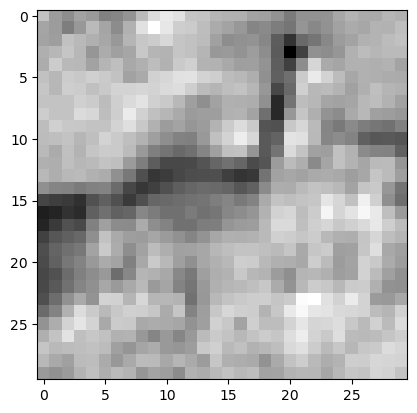

In [10]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

#### 8.2.1 경계 패딩하기


In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

#### 8.2.2 컨볼루션으로 피처 찾아내기


In [12]:
# bias를 0으로 제거해, 교란 변수 배제
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

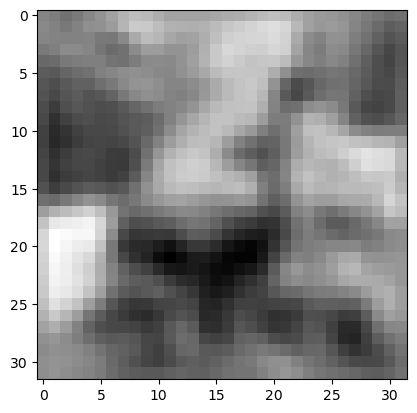

In [13]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

각 출력 픽셀은 자신의 주변 픽셀에 대한 평균이기 때문에 출력 픽셀에서 이러한 상관관계를 반영해 픽셀 간의 변화가 부드러워짐

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

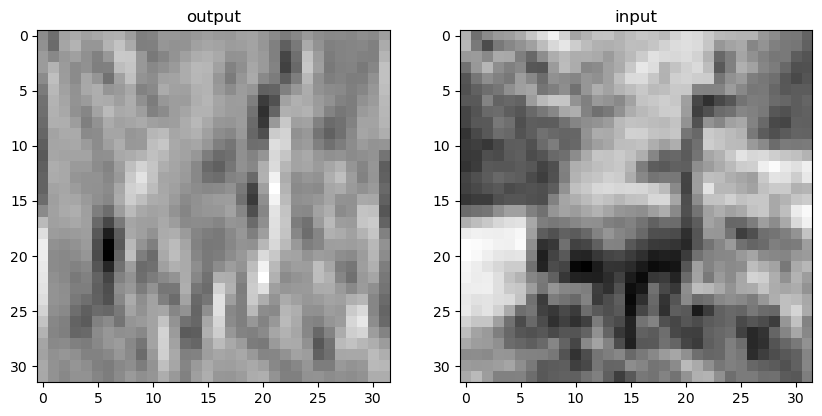

In [17]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))
ax1 = plt.subplot(1, 2, 1)
plt.title('output')
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
plt.imshow(img.mean(0), cmap='gray') 
plt.title('input')
plt.show()

#### 8.2.3 깊이와 풀링으로 한 단계 더 인식하기
- 큰 사이즈의 커널을 사용하면, 완전 연결된 아핀 변환으로 수렴해서 컨볼루션의 장점을 잃어버리게 됨
- 컨볼루션을 차례로 층층이 쌓으면서 동시에 연속적인 컨볼루션 사이의 이미지를 다운 샘플링하는 방법이 있음

##### 큰 이미지에서 작은 이미지로: 다운샘플링
- 평균 풀링(average pooling)
- 맥스 풀링(max pooling)
- 스트라이드하며 컨볼루션을 수행하되 n번째 픽셀만 계산하기

In [18]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

#### 8.2.4 우리의 신경망에 적용하기

In [20]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ...
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [21]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

### 8.3 nn.Module 서브클래싱하기
- 기존에 만들어진 모듈에서 지원하지 않는 연산이 필요할 때가 있음
- 서브클래싱을 위해서는, `forward` 함수를 정의하여 모듈로 입력을 전달하고 출력을 반환하게 해야 함
- 표준 `torch` 연산을 사용하기만 한다면, 자동미분 기능이 자동으로 역방향 경로를 만들어주기에 `nn.Module`에는 `backward`가 필요 없음

#### 8.3.1 nn.Module로 정의된 신경망


In [22]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8) # 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

분류 신경망의 목적은 일반적으로 큰 수의 픽셀을 가진 이미지에서 출발해 정보를 압축해가면서 분류 클래스(확률 벡터)로 만들어가는 것  
1. 중간에 나타나는 값의 개수가 점점 줄어드는 모습에 목표한 바가 반영
   1. 컨볼루션의 채널 수가 점점 줄어들고 풀링에서 픽셀 수가 줄어들며 선형 계층에서는 입력 차원보다 낮은 수의 차원을 출력
   2. 풀링시 공간 분해능(spatial resolution) 감소가 있더라도 채널의 수는 늘어남 (전체 사이즈는 결과적으로 감소)
   3. 빠르게 정보를 축소하는 패턴은 제한된 깊이의 신경망과 작은 이미지에 대해서는 잘 동작하지만, 신경망이 깊어질수록 감소는 천천히 일어남
2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않음

#### 